In [1]:
# IMPORTING PACKAGES
!pip install trimesh

import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.7/694.7 kB 4.7 MB/s eta 0:00:00


2024-06-11 12:06:44.229160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 12:06:44.229276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 12:06:44.422099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Using hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available:", len(physical_devices))
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found")

GPUs Available: 2


In [3]:
#Downloading Data
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473402300/473402300 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
#Visualise a mesh from the data set
mesh=trimesh.load(os.path.join(DATA_DIR,"chair/train/chair_0001.off"))
mesh.show

<bound method Trimesh.show of <trimesh.Trimesh(vertices.shape=(844, 3), faces.shape=(2234, 3), name=`chair_0001.off`)>>

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

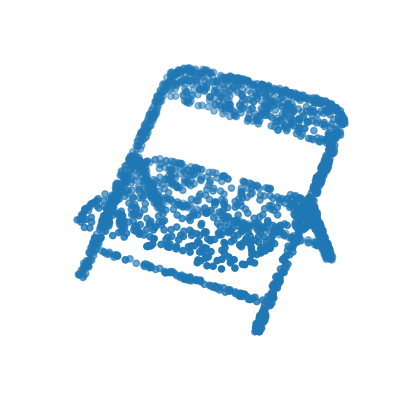

In [5]:
#Samplea mesh and show result

points=mesh.sample(2048)

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.imshow

In [6]:
#Parsing Dataset
def parse_dataset(num_points=4096):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
    
    for i, folder in enumerate(folders):
        print("Processing class: {}".format(os.path.basename(folder)))
        # Store folder name with ID to retrieve later
        class_map[i] = folder.split("/")[-1]
        # Gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
        
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map
    )

In [7]:
#Parse the dataset and process each class
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

Processing class: monitor
Processing class: bathtub
Processing class: table
Processing class: dresser
Processing class: night_stand
Processing class: sofa
Processing class: bed
Processing class: toilet
Processing class: chair
Processing class: desk


In [8]:
#Augmentation for each class
def augment(points, label):
    # Jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # Shuffle points
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=3, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [9]:
#T-net Layers Function
def tnet(inputs, num_features):
    # Initialize bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer='zeros',
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [10]:
#CNN
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2046, 32)  │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2046, 32)  │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2046, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2044, 64)  │      6,208 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2044, 64)  │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2044, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2042, 512) │     98,816 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2042, 512) │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 2042, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 9)         │      1,161 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3)      │          0 │ dense_2[0][0]   

 Total params: 964,403 (3.68 MB)

 Trainable params: 958,323 (3.66 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25


I0000 00:00:1718108067.837454      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718108067.893638      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108067.897157      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108067.899328      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108067.901143      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2285 - loss: 43.4283

W0000 00:00:1718108096.901538      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108096.904931      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108096.906989      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108096.909241      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108098.981818      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108098.985237      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718108098.987546      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 271ms/step - accuracy: 0.2288 - loss: 43.3891 - val_accuracy: 0.2104 - val_loss: 266637559201792.0000
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.3240 - loss: 36.3963 - val_accuracy: 0.2434 - val_loss: 509180016328704.0000
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.3577 - loss: 35.9445 - val_accuracy: 0.2544 - val_loss: 5742905461309440.0000
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.3641 - loss: 35.8779 - val_accuracy: 0.2742 - val_loss: 2856408265523200.0000
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3780 - loss: 35.9039 - val_accuracy: 0.2203 - val_loss: 1217685.2500
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.4052 - loss: 35.7723 - val_accuracy: 0.2434 - val_loss: 4172979755810816.0000
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.4021 - loss: 35.7159 - val_accuracy: 0.2885 - val_loss: 87835459584.000

In [12]:
import tensorflow as tf

# Save the model in HDF5 format
model.save("pointnet_model.h5")

# Save the model in TensorFlow SavedModel format
tf.saved_model.save(model, "pointnet_model_savedmodel")


In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7203 - loss: 1845587716704567296.0000
Test loss: 5.15568863772305e+18
Test accuracy: 0.7125550508499146


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


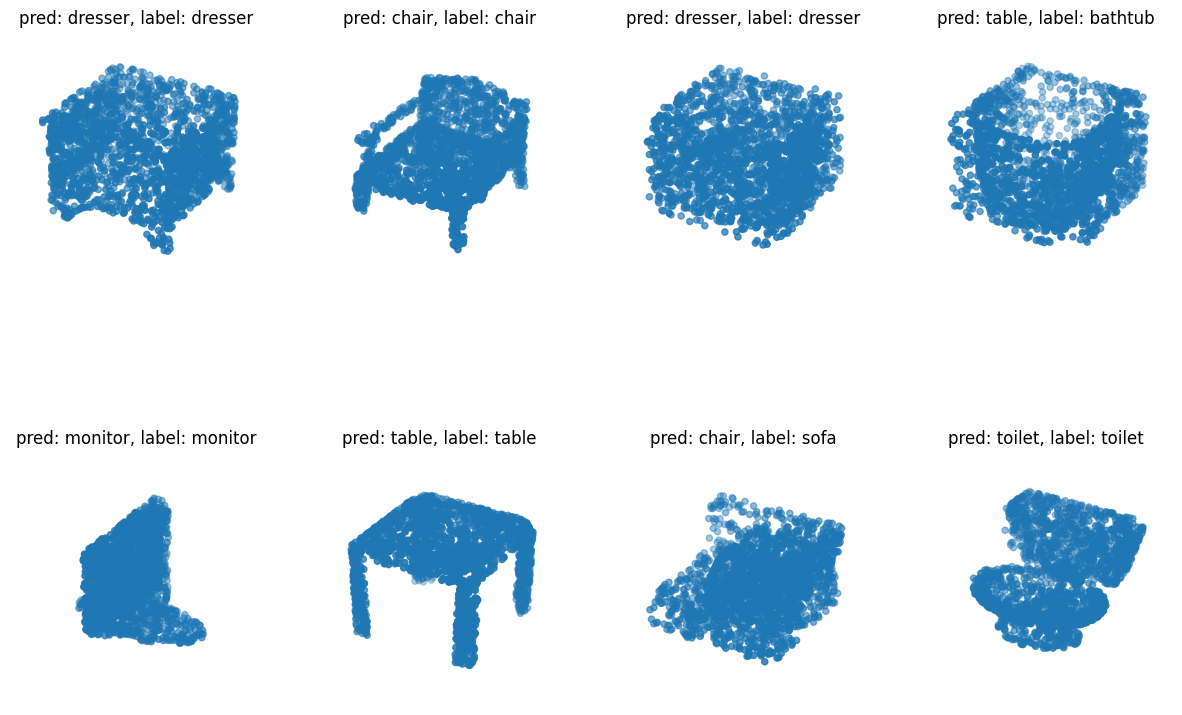

In [14]:
# Extract a batch of data from the test dataset
data = test_dataset.take(1)
points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# Run test data through the model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# Plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection='3d')
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()

plt.show()